# HDFS Log Anomaly Detection - Part 1: EDA & Preprocessing

## Objective
Exploratory Data Analysis and preprocessing of HDFS_v1 logs for anomaly detection

## Dataset Information
- **Source**: LogHub - HDFS_v1 dataset
- **Description**: Contains system logs from HDFS (Hadoop Distributed File System)
- **Format**: Unstructured log messages with timestamps
- **Goal**: Identify anomalies using Isolation Forest and One-Class SVM

## 1. Setup & Dependencies

In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
from google.colab import drive
drive.mount('/content/drive')
print('✓ Dependencies loaded successfully')

Mounted at /content/drive
✓ Dependencies loaded successfully


## 2. Download HDFS_v1 Dataset from KAGGLE

In [2]:
from google.colab import files
files.upload()

# config de kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#charger dateset
!kaggle datasets download -d ayenuryrr/loghub-hdfs-hadoop-distributed-file-system-data
!unzip -q loghub-hdfs-hadoop-distributed-file-system-data.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ayenuryrr/loghub-hdfs-hadoop-distributed-file-system-data
License(s): Attribution 4.0 International (CC BY 4.0)
100% 1.55G/1.55G [00:12<00:00, 173MB/s]
100% 1.55G/1.55G [00:12<00:00, 138MB/s]



## 3. Load and Inspect Raw Data

In [4]:

# Load HDFS logs
log_file = '/content/HDFS_v1/HDFS.log'

# Read raw logs
with open(log_file, 'r') as f:
    raw_logs = f.readlines()

print(f'Total log lines: {len(raw_logs)}')
print(f'\nFirst 5 log entries:')
for i, log in enumerate(raw_logs[:5]):
    print(f'{i+1}: {log.strip()}')

Total log lines: 11175629

First 5 log entries:
1: 081109 203518 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.19.102:54106 dest: /10.250.19.102:50010
2: 081109 203518 35 INFO dfs.FSNamesystem: BLOCK* NameSystem.allocateBlock: /mnt/hadoop/mapred/system/job_200811092030_0001/job.jar. blk_-1608999687919862906
3: 081109 203519 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.10.6:40524 dest: /10.250.10.6:50010
4: 081109 203519 145 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.14.224:42420 dest: /10.250.14.224:50010
5: 081109 203519 145 INFO dfs.DataNode$PacketResponder: PacketResponder 1 for block blk_-1608999687919862906 terminating


##4. Data Structuring (Parsing)

In [8]:
#We will transform each line of text into columns (Date, Time, Level, Component, Content) and extract the Block_ID
def parse_hdfs_logs(log_lines, limit=200000):
    parsed_data = []
    # Regex optimized for HDFS format
    # Format: Date Time PID Level Component: Content
    line_format = re.compile(r'^(\d{6})\s+(\d{6})\s+(\d+)\s+(\w+)\s+([\w\.\$\d]+):\s+(.*)$')

    for line in tqdm(log_lines[:limit]):
        match = line_format.match(line.strip())
        if match:
            date, time, pid, level, component, content = match.groups()
            # Extracting the Block ID (join key for the anomaly)
            block_match = re.search(r'(blk_-?\d+)', content)
            block_id = block_match.group(1) if block_match else "None"

            parsed_data.append({
                'Date': date, 'Time': time, 'Level': level,
                'Component': component, 'Content': content, 'BlockId': block_id
            })

    return pd.DataFrame(parsed_data)

# On traite un échantillon pour l'EDA
df_logs = parse_hdfs_logs(raw_logs, limit=1000000)
df_logs.head()

100%|██████████| 1000000/1000000 [00:06<00:00, 146009.86it/s]


,Date,Time,Level,Component,Content,BlockId
0,081109,203518,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,blk_-1608999687919862906
1,081109,203518,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,blk_-1608999687919862906
2,081109,203519,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,blk_-1608999687919862906
3,081109,203519,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,blk_-1608999687919862906
4,081109,203519,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,blk_-1608999687919862906


##5. Analyse Exploratoire (EDA)

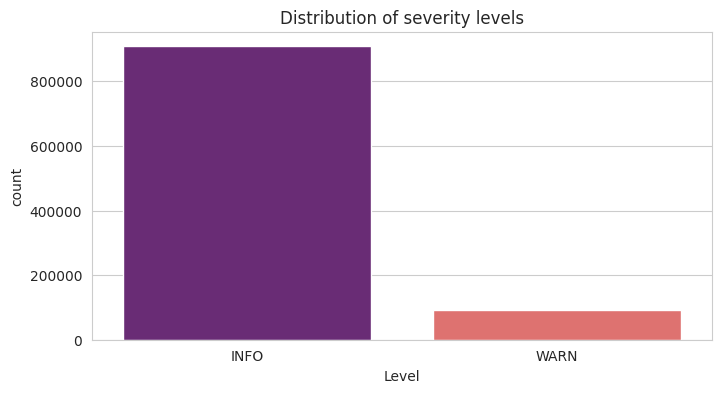

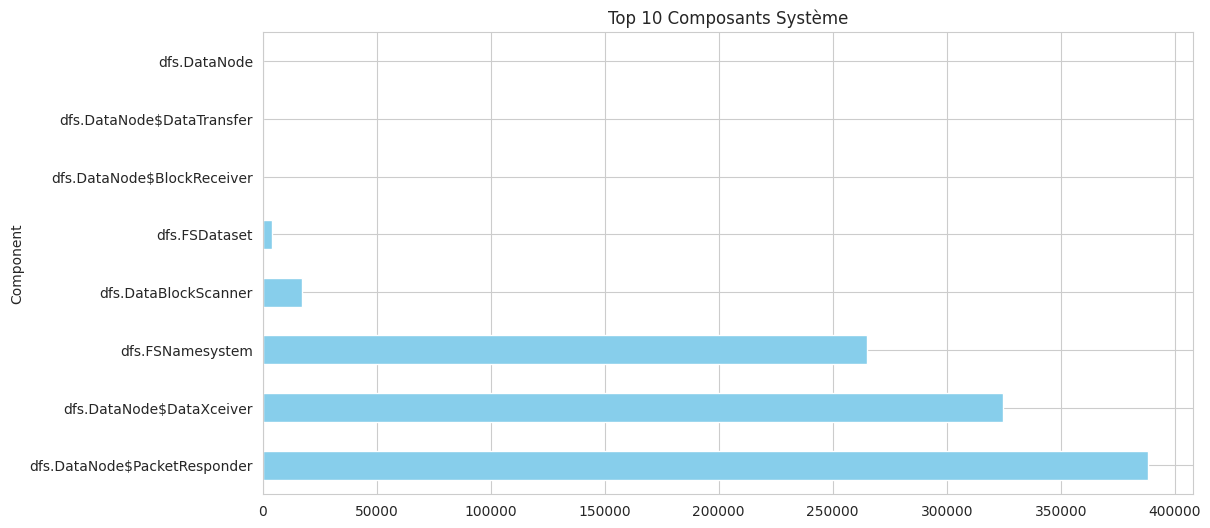

In [10]:
#Understanding log distribution is crucial before applying AI.

#1. Distribution by level (INFO vs WARN)
plt.figure(figsize=(8, 4))
sns.countplot(data=df_logs, x='Level', palette='magma')
plt.title("Distribution of severity levels")
plt.show()

#2. Top 10 Most Chatty Components
df_logs['Component'].value_counts().head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Composants Système")
plt.show()

##6. Loading the Anomaly Labels


Anomaly distribution (Ground Truth):
Label
Normal     558223
Anomaly     16838
Name: count, dtype: int64


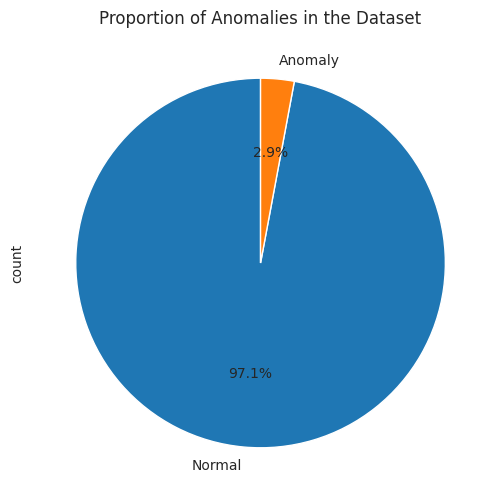

In [11]:
#The LogHub dataset provides a file named anomaly_label.csv that links each BlockId to its state (Normal or Anomaly).
# Load the labels
labels_file = '/content/HDFS_v1/preprocessed/anomaly_label.csv'
df_labels = pd.read_csv(labels_file)

# Check class imbalance
print("Anomaly distribution (Ground Truth):")
print(df_labels['Label'].value_counts())

# Visualization
df_labels['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("Proportion of Anomalies in the Dataset")
plt.show()

##7. Filtering and Preparation

In [14]:
save_path = '/content/drive/MyDrive/HDFS_Project/'
import os
os.makedirs(save_path, exist_ok=True)

# Remove logs without a valid BlockId
df_clean = df_logs[df_logs['BlockId'] != "None"].copy()

# Save for Notebook 02:Feature Engineering.
df_clean.to_csv(save_path + 'hdfs_cleaned_sample.csv', index=False)
df_labels.to_csv(save_path + 'labels_cleaned.csv', index=False)

print(f"Cleaning completed. {len(df_clean)} rows ready for feature engineering.")

Cleaning completed. 1000000 rows ready for feature engineering.
